In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
%load_ext autoreload
%autoreload 2
import brandear_est as be

In [4]:
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_OUTPUT_DIR = os.path.join(IMD_DIR, "valid_aucs")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_valid_aucs")

dset_to_period = {
    "pre_train": {"oldest": datetime.datetime(2019, 8, 26, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 3, 0, 0, 0)},    
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [5]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()

In [6]:
def extract_target_actions(watch, bid, period):
    watch_actioned = (
        watch.loc[(watch["TourokuDate"] >= period["oldest"]) & (watch["TourokuDate"] < period["newest"]),
                  ["KaiinID", "AuctionID"]]
    )
    bid_actioned = (
        bid.loc[(bid["ShudouNyuusatsuDate"] >= period["oldest"]) & (bid["ShudouNyuusatsuDate"] < period["newest"]),
                ["KaiinID", "AuctionID"]]
    )

    watch_actioned["watch_actioned"] = 1
    bid_actioned["bid_actioned"] = 1

    target_actions = (
        watch_actioned
        .merge(bid_actioned, on=["KaiinID", "AuctionID"], how="outer")
        .drop_duplicates()
        .fillna(0)
    )
    return target_actions

    
def arrange_dtime_condition(watch, bid, bid_success, auction, period):
    retval = ((
        watch[watch["TourokuDate"] <= period["oldest"]],
        bid[bid["ShudouNyuusatsuDate"] <= period["oldest"]],
        bid_success[bid_success["RakusatsuDate"] < period["oldest"]],
        auction[auction["CreateDate"] < period["newest"]]
    ))
    return retval
    

def arrange_inputs(watch, bid, bid_success, auction, period):
    
    target_actions = extract_target_actions(watch, bid, period)
    
    watch_t, bid_t,  bid_success_t, auction_t = (
        arrange_dtime_condition(watch, bid, bid_success, auction, period)
    )
    
    arranged_inputs = (
        watch_t.merge(auction_t, on="AuctionID", how="left"),
        bid_t.merge(auction, on="AuctionID", how="left"),
        bid_success_t,
        auction_t,
        target_actions
    )
    return arranged_inputs

def extract_recent_data(df, date_col, base_dtime, days):
    oldest_dtime = base_dtime - relativedelta(days=days)
    return df[df[date_col] > oldest_dtime]

In [7]:
def build_dataset_input(auction, bid_success, watch, bid, period):
    
    watch_arranged, bid_arranged, bid_success_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, bid_success=bid_success, auction=auction, period=period)
    )

    # 落札しているオークションを除外
    aucs_with_cnts = be.left_anti_join(auction_arranged, bid_success_arranged, "AuctionID", "AuctionID")
    
    # 正解データ付与
    target_aucs = target_actions[["AuctionID", "watch_actioned", "bid_actioned"]].groupby("AuctionID", as_index=False).max()
    aucs_with_cnts = aucs_with_cnts.merge(target_aucs, on="AuctionID", how="left").fillna(0)    
    
    # クロス集計
    # クロス集計用にオークションデータ結合
    newest_dtime, oldest_dtime = (period["newest"], period["oldest"])        
    cross_conf = {
        "watch": watch_arranged,
        "bid": bid_arranged,
        "7d_watch": extract_recent_data(watch_arranged, "TourokuDate", oldest_dtime, 7),
        "7d_bid": extract_recent_data(bid_arranged, "ShudouNyuusatsuDate", oldest_dtime, 7)
    }
    col_sets = [["AuctionID"], ["ShouhinID"], ["BrandID"], ["LineID"]]
    
    for prefix, feature_df in cross_conf.items():
        aucs_with_cnts = be.add_cross_counts(aucs_with_cnts, feature_df, prefix=prefix, col_sets=col_sets)
    
    
    # 経過日数の特徴量
    aucs_with_time = aucs_with_cnts
    aucs_with_time["elapsed_days"] = aucs_with_time["CreateDate"].apply(lambda d: (newest_dtime - d).days)
    
    dtime_feat_confs = [["watch", "TourokuDate", watch_arranged],
                       ["bid", "ShudouNyuusatsuDate", bid_arranged]]
    for dtime_feat_conf in dtime_feat_confs:
        prefix = dtime_feat_conf[0]
        last_action = (
            dtime_feat_conf[2][["AuctionID", dtime_feat_conf[1]]]
            .groupby("AuctionID", as_index=False).max()
            .rename(columns={dtime_feat_conf[1]: f"{prefix}_elapsed_days"})
        )
        last_action[f"{prefix}_elapsed_days"] = last_action[f"{prefix}_elapsed_days"].swifter.apply(lambda d: (oldest_dtime - d).days)
        aucs_with_time = aucs_with_time.merge(last_action, on="AuctionID", how="left").fillna(999)    

    return aucs_with_time


In [8]:
pre_train_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["pre_train"])

##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']


In [7]:
%%time
pre_train_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["pre_train"])
train_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["train"])
vt_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["valid_for_train"])
vs_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["valid_for_sub"])
sub_dataset_input = build_dataset_input(auction, bid_success, watch, bid, dset_to_period["submission"])

In [10]:
# be.df2pkl(pre_train_dataset_input, IMD_ARCHIVE_DIR, "watch_pre_train_feature.pkl")

In [8]:
# be.to_pickle(train_dataset_input, IMD_DIR, "train_dataset_input.pkl")
# be.to_pickle(vt_dataset_input, IMD_DIR, "vt_dataset_input.pkl")
# be.to_pickle(vs_dataset_input, IMD_DIR, "vs_dataset_input.pkl")
# be.to_pickle(sub_dataset_input, IMD_DIR, "sub_dataset_input.pkl")

train_dataset_input.pkl : 202001310957
vt_dataset_input.pkl : 202001310958
vs_dataset_input.pkl : 202001310958
sub_dataset_input.pkl : 202001310958


In [7]:
pre_train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/pre_train_feature.pkl")
train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/train_feature.pkl")
vt_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_train_feature.pkl")
vs_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_sub_feature.pkl")
sub_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/submission_feature.pkl")

In [8]:
drop_cols = ["AuctionID", "watch_actioned", "bid_actioned","CreateDate",
             "ShouhinID", "BrandID", "GenreID", "GenreGroupID", "ColorID", "pred"]

# watch_ptr_dataset = be.DataSet(data=pre_train_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
# watch_tr_dataset = be.DataSet(data=train_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
# watch_vt_dataset = be.DataSet(data=vt_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
# watch_vs_dataset = be.DataSet(data=vs_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
# watch_sub_dataset = be.DataSet(data=sub_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")

# bid_ptr_dataset = be.DataSet(data=pre_train_dataset_input, drop_cols=drop_cols, target_col="bid_actioned")
# bid_tr_dataset = be.DataSet(data=train_dataset_input, drop_cols=drop_cols, target_col="bid_actioned")
# bid_vt_dataset = be.DataSet(data=vt_dataset_input, drop_cols=drop_cols, target_col="bid_actioned")
# bid_vs_dataset = be.DataSet(data=vs_dataset_input, drop_cols=drop_cols, target_col="bid_actioned")
# bid_sub_dataset = be.DataSet(data=sub_dataset_input, drop_cols=drop_cols, target_col="bid_actioned")


In [74]:
# # 学習の様子可視化
for target, dataset in {"watch": bid_vs_dataset}.items():
    print(target)
    
    # train test split
    train_dataset, test_dataset =be.DataSet.train_test_split(dataset)
    sampled_train = be.DataSet.under_sampling(train_dataset)

    # target encoding
    cat_col = "BrandID"
    sampled_train.add_target_encode(cat_col=cat_col)
    be.target_encode_for_test(train_dataset=sampled_train, test_dataset=test_dataset, cat_col=cat_col)    
    
    lgb_bi = be.LgbBinaryClassifier()
    lgb_bi.train(train_dataset=sampled_train, valid_dataset=test_dataset, desc=True)    

watch
[1]	valid_0's auc: 0.968667
[2]	valid_0's auc: 0.969011
[3]	valid_0's auc: 0.969093
[4]	valid_0's auc: 0.96908
[5]	valid_0's auc: 0.969609
[6]	valid_0's auc: 0.969677
[7]	valid_0's auc: 0.96993
[8]	valid_0's auc: 0.969981
[9]	valid_0's auc: 0.970003
[10]	valid_0's auc: 0.97006
[11]	valid_0's auc: 0.970077
[12]	valid_0's auc: 0.971435
[13]	valid_0's auc: 0.971525
[14]	valid_0's auc: 0.971554
[15]	valid_0's auc: 0.9716
[16]	valid_0's auc: 0.971597
[17]	valid_0's auc: 0.971661
[18]	valid_0's auc: 0.971682
[19]	valid_0's auc: 0.971685
[20]	valid_0's auc: 0.9717
[21]	valid_0's auc: 0.97171
[22]	valid_0's auc: 0.971834
[23]	valid_0's auc: 0.971839
[24]	valid_0's auc: 0.971838
[25]	valid_0's auc: 0.971845
[26]	valid_0's auc: 0.971872
[27]	valid_0's auc: 0.97188
[28]	valid_0's auc: 0.971874
[29]	valid_0's auc: 0.971896
[30]	valid_0's auc: 0.971887
[31]	valid_0's auc: 0.971947
[32]	valid_0's auc: 0.971989
[33]	valid_0's auc: 0.972032
[34]	valid_0's auc: 0.972061
[35]	valid_0's auc: 0.9720

In [75]:
# 予測値取得

dataset_pairs = [
#     [watch_ptr_dataset, watch_tr_dataset],
#     [watch_tr_dataset, watch_vt_dataset],
#     [watch_vt_dataset, watch_vs_dataset],
#     [watch_vs_dataset, watch_sub_dataset],
    [bid_ptr_dataset, bid_tr_dataset],
    [bid_tr_dataset, bid_vt_dataset],
    [bid_vt_dataset, bid_vs_dataset],
    [bid_vs_dataset, bid_sub_dataset],    
]

for train_dataset, sub_dataset in dataset_pairs:
    
    sampled_train = be.DataSet.under_sampling(train_dataset)
    # target encoding
    cat_col = "BrandID"
    sampled_train.add_target_encode(cat_col=cat_col)
    be.target_encode_for_test(train_dataset=train_dataset, test_dataset=sub_dataset, cat_col=cat_col)    
    lgb_bi.train(train_dataset=sampled_train)
    sub_dataset.set_pred(lgb_bi.predict(sub_dataset))    

watch
auc :  0.9078185704556132


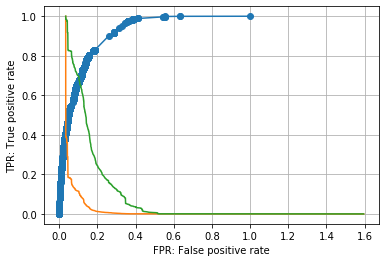

In [67]:
target = "watch"
dataset = watch_tr_dataset
print(target)
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
be.plot_roc_curve(dataset.get_target(), dataset.data.pred)
be.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)

bid
auc :  0.9718533851424488


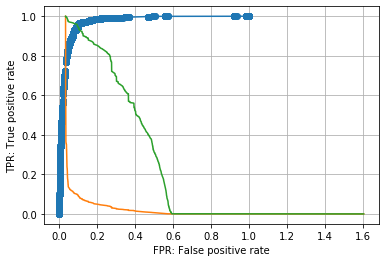

In [76]:
target = "bid"
dataset = bid_vs_dataset
print(target)
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
be.plot_roc_curve(dataset.get_target(), dataset.data.pred)
be.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)

In [10]:
def show_th_info(th, dataset):
    print("threshold : ", th)
    print("data size : ", dataset.data.shape[0])
    print("True count : ", dataset.data.query(f"({dataset.target_col} == 1)").shape[0])
    print("True and False larger than threshold : ", dataset.data.query(f"pred >= {th}").shape[0])
    print("True larger than threshold : ", dataset.data.query(f"(pred >= {th}) & ({dataset.target_col} == 1)").shape[0])

In [78]:
show_th_info(th=0.3, dataset=watch_tr_dataset)

threshold :  0.3
data size :  3473433
True count :  58372
True and False larger than threshold :  19283
True larger than threshold :  7230


In [16]:
tmp = pd.read_pickle(IMD_OUTPUT_DIR + "/bid_valid_for_sub.pkl")
bid_vs_dataset = be.DataSet(data=tmp, drop_cols=drop_cols, target_col="bid_actioned")
show_th_info(th=0.56, dataset=bid_vs_dataset)

threshold :  0.56
data size :  3596238
True count :  9153
True and False larger than threshold :  6416
True larger than threshold :  1166


In [86]:
df2pkl(watch_tr_dataset.data, IMD_OUTPUT_DIR, "watch_train.pkl")
# be.to_pickle(watch_vt_dataset.data, IMD_DIR, "watch_vt_dataset.pkl")
# be.to_pickle(watch_vs_dataset.data, IMD_DIR, "watch_vs_dataset.pkl")
# be.to_pickle(watch_sub_dataset.data, IMD_DIR, "watch_sub_dataset.pkl")

df2pkl(bid_tr_dataset.data, IMD_OUTPUT_DIR, "bid_train.pkl")
df2pkl(bid_vt_dataset.data, IMD_OUTPUT_DIR, "bid_valid_for_train.pkl")
df2pkl(bid_vs_dataset.data, IMD_OUTPUT_DIR, "bid_valid_for_sub.pkl")
df2pkl(bid_sub_dataset.data, IMD_OUTPUT_DIR, "bid_submission.pkl")

In [22]:
for dset_type, period in dset_to_period.items():
    print(dset_type)
    tmp = extract_target_actions(watch, bid, period)
    print("件数 : ", tmp.shape[0])
    print("watch : ", tmp.query("watch_actioned == 1")[["AuctionID"]].drop_duplicates().shape[0])
    print("bid : ", tmp.query("bid_actioned == 1")[["AuctionID"]].drop_duplicates().shape[0])
    print("watch and bid : ", tmp.query("(watch_actioned == 1) & (bid_actioned == 1)")[["AuctionID"]].drop_duplicates().shape[0])    

pre_train
件数 :  88637
watch :  61784
bid :  10392
watch and bid :  4429
train
件数 :  82729
watch :  58425
bid :  8672
watch and bid :  3638
valid_for_train
件数 :  89910
watch :  62536
bid :  9042
watch and bid :  3743
valid_for_sub
件数 :  91044
watch :  64555
bid :  9153
watch and bid :  3852
submission
件数 :  0
watch :  0
bid :  0
watch and bid :  0


In [19]:
extract_target_actions(watch, bid, dset_to_period["pre_train"])

,KaiinID,AuctionID,watch_actioned,bid_actioned
0,220095,300285,1.0,0.0
1,222537,2438868,1.0,0.0
2,59964,2250447,1.0,0.0
3,90462,2582548,1.0,0.0
4,18739,1084034,1.0,0.0
...,...,...,...,...
90355,68248,1323870,0.0,1.0
90356,218663,1323870,0.0,1.0
90357,187590,1527196,0.0,1.0
90358,170490,2449338,0.0,1.0
